<a href="https://colab.research.google.com/github/djakesa/AE-VAE-GAN-CelebA/blob/main/morphing_smile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
import os
import shutil

# Démontage s'il est déjà monté
try:
    !fusermount -u /content/drive
except:
    pass

# Suppression du dossier de montage s'il reste
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive', ignore_errors=True)

# Montage propre
drive.mount('/content/drive', force_remount=True)

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


In [63]:
import pandas as pd

attr_file = "/content/drive/MyDrive/CelebA/Anno/list_attr_celeba.txt"
attrs = pd.read_csv(attr_file, sep="\s+", skiprows=1)

In [64]:
# Sélectionne 300 visages chauve et 300 sans
n = 300
with_bald = attrs[attrs["Bald"] == 1].sample(n, random_state=42)
without_bald = attrs[attrs["Bald"] == -1].sample(n, random_state=42)


In [65]:
import cv2

def load_and_preprocess(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    return img


In [66]:
# Imports
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf
import numpy as np
import json
import os

# Classe Sampling (doit correspondre à celle utilisée à l'entraînement)
class Sampling(Layer):
    def __init__(self, z_dim, beta=1.0, **kwargs):
        super(Sampling, self).__init__(**kwargs)
        self.z_dim = z_dim
        self.beta = beta
        self.mu_prior = self.add_weight(name='mu_prior', shape=(self.z_dim,), initializer='zeros', trainable=True)
        self.log_var_prior = self.add_weight(name='log_var_prior', shape=(self.z_dim,), initializer='zeros', trainable=True)

    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(0.5 * log_var) * epsilon
        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - self.log_var_prior
            - tf.exp(log_var) / tf.exp(self.log_var_prior)
            - tf.square(mu - self.mu_prior) / tf.exp(self.log_var_prior),
            axis=1
        )
        self.add_loss(self.beta * tf.reduce_mean(kl_loss))
        return z

# Classe VAE minimale pour load uniquement
class VAE():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size,
                 decoder_conv_t_strides, z_dim, use_batch_norm=False, use_dropout=False):
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

    @classmethod
    def load(cls, path):
        with open(os.path.join(path, "config.json"), "r") as f:
            config = json.load(f)

        vae = cls(**config)
        vae.model = load_model(os.path.join(path, "vae_model.keras"), custom_objects={"Sampling": Sampling}, compile=False)
        vae.encoder = load_model(os.path.join(path, "encoder_model.keras"), custom_objects={"Sampling": Sampling}, compile=False)
        vae.decoder = load_model(os.path.join(path, "decoder_model.keras"), compile=False)

        return vae


In [67]:
img_dir = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'

vae = VAE.load("/content/drive/MyDrive/vae_celeba")

# === Fonction de chargement + vérification image ===
def load_and_preprocess(img_path):
    if not os.path.isfile(img_path):
        print(f"[ABSENT] {img_path}")
        return None
    img = cv2.imread(img_path)
    if img is None:
        print(f"[INVALIDE] {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    return img

# === Encodage des visages chauves ===
z_bald = []
print("Encodage des visages chauves...")
for img_name in with_bald.index:
    path = os.path.join(img_dir, img_name)
    img = load_and_preprocess(path)
    if img is None:
        continue
    z = vae.encoder.predict(np.expand_dims(img, axis=0))
    z_bald.append(z[0])
z_bald = np.array(z_bald)

# === Encodage des visages non chauves ===
z_not_bald = []
print("Encodage des visages non chauves...")
for img_name in without_bald.index:
    path = os.path.join(img_dir, img_name)
    img = load_and_preprocess(path)
    if img is None:
        continue
    z = vae.encoder.predict(np.expand_dims(img, axis=0))
    z_not_bald.append(z[0])
z_not_bald = np.array(z_not_bald)

# === Calcul de la direction "chauve" ===
direction_bald = np.mean(z_bald, axis=0) - np.mean(z_not_bald, axis=0)

# === Sauvegarde dans Drive ===
np.save("/content/drive/MyDrive/direction_bald.npy", direction_bald)
print(" Direction 'Bald' enregistrée avec succès.")

Encodage des visages chauves...
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/020222.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/114143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/172596.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/005361.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/079387.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/177252.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/158719.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/103859.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/143579.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/187379.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/052585.jpg
[ABSENT] /content/drive/MyDrive/img_align_celeba/img_align_celeba/036174.jpg
[ABSE

In [68]:
print (direction_bald)

[-1.04583919e-01  5.01077294e-01  1.18507005e-01 -2.59906471e-01
  1.92922056e-02  4.16983247e-01  4.93097007e-01  1.19712877e+00
 -6.71631217e-01 -4.30548787e-01  2.19144702e-01 -1.02218270e-01
  6.29778057e-02 -2.63607502e-01  5.65289736e-01  5.10834694e-01
 -3.04201216e-01  5.16169429e-01  3.27173769e-02  8.79056156e-02
 -2.41175011e-01 -5.50092995e-01 -5.13254523e-01  9.54577148e-01
  2.91934311e-01 -3.47339213e-02  7.06716478e-02  2.97860593e-01
  6.73242688e-01 -6.96441829e-01  9.45944190e-02 -2.24238813e-01
  3.23239475e-01 -1.48226872e-01 -1.79997158e+00  2.61140883e-01
  1.06099233e-01  4.98020768e-01  4.87223148e-01  3.81407976e-01
  2.72310227e-02  5.98311901e-01  1.66175425e-01 -2.35639393e-01
 -5.49725890e-01 -2.01830268e-03  7.83866346e-01 -7.92738616e-01
  1.24944758e+00  1.57086670e-01  3.00668120e-01 -6.56794071e-01
 -4.55055922e-01 -2.65462130e-01 -2.76211470e-01  3.53801370e-01
 -2.35264480e-01 -6.16841972e-01  6.89994991e-01 -8.61773968e-01
  1.47438794e-02 -1.26934

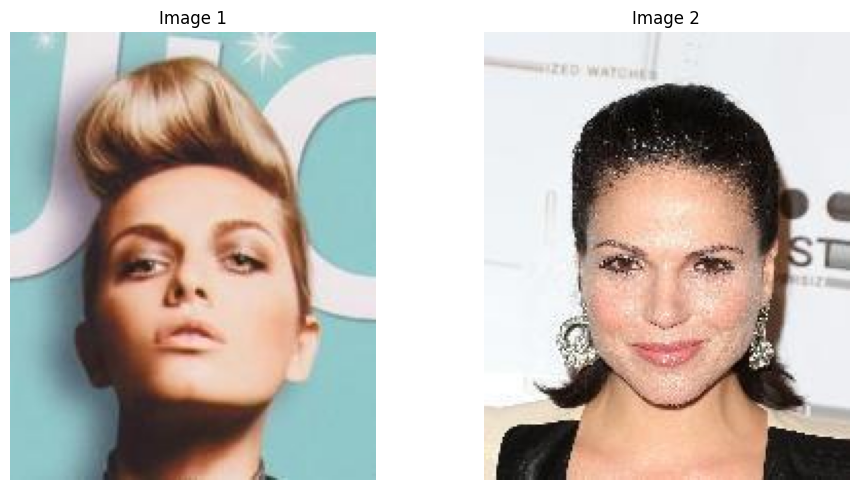

In [73]:
import cv2
import matplotlib.pyplot as plt

# === Chemins des deux images ===
img_path_1 = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/000005.jpg'
img_path_2 = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/005000.jpg'

# === Chargement et conversion RGB ===
img1 = cv2.imread(img_path_1)
img2 = cv2.imread(img_path_2)

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# === Affichage côte à côte ===
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


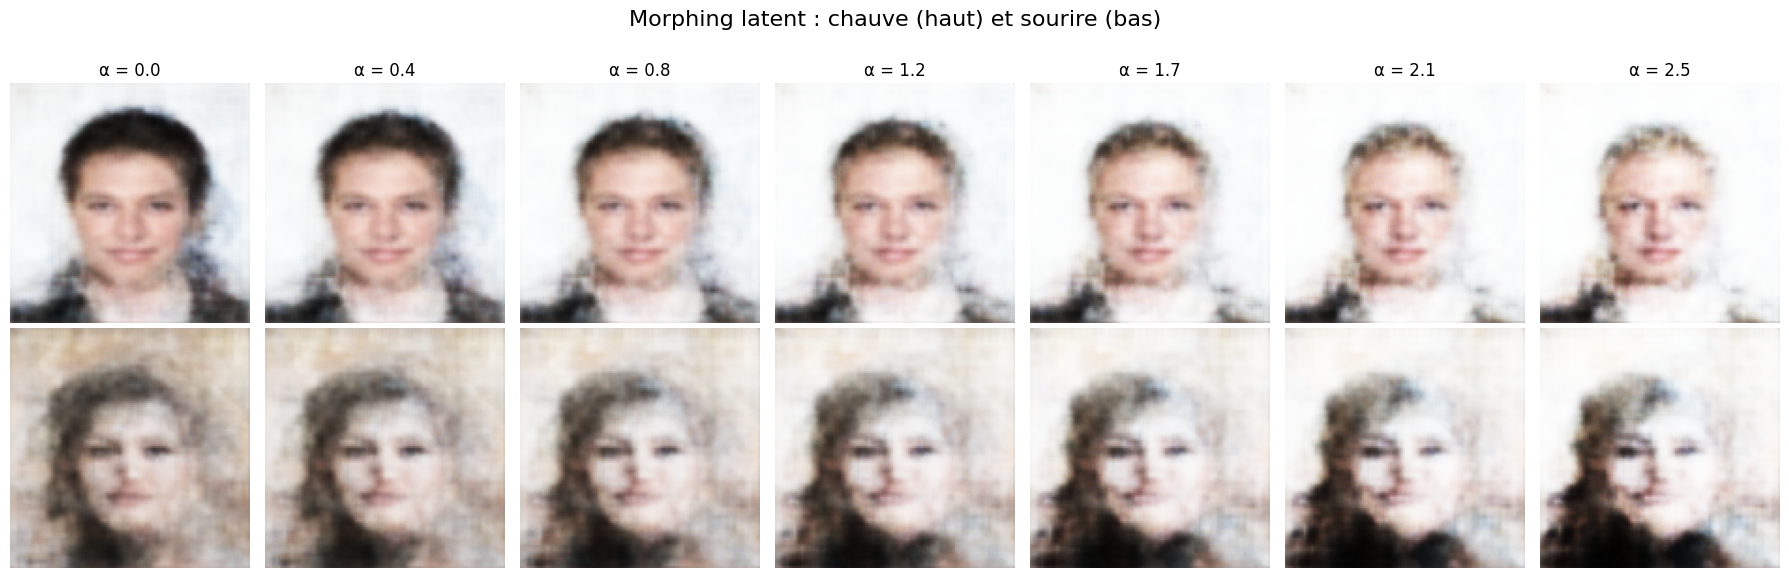

In [74]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Chemins ===
vae_model_dir = "/content/drive/MyDrive/vae_celeba"
direction_path_bald = "/content/drive/MyDrive/direction_bald.npy"
direction_path_smile = "/content/drive/MyDrive/direction_smile.npy"

#img_path_1 pour sourire
#img_path_2  pour chauve

# === Chargement du modèle et des directions ===
vae = VAE.load(vae_model_dir)
direction_bald = np.load(direction_path_bald)
direction_smile = np.load(direction_path_smile)

# === Chargement et encodage des deux images ===
img_sourire = load_and_preprocess(img_path_1)
img_chauve = load_and_preprocess(img_path_2)

if img_sourire is None or img_chauve is None:
    raise ValueError("Erreur de chargement des images.")

z_sourire = vae.encoder.predict(np.expand_dims(img_sourire, axis=0))[0]
z_chauve = vae.encoder.predict(np.expand_dims(img_chauve, axis=0))[0]

# === Morphing ===
alphas = np.linspace(0, 2.5, 7)

plt.figure(figsize=(18, 6))

# Ligne 1 : morphing chauve
for i, alpha in enumerate(alphas):
    z_morph_bald = z_chauve + alpha * direction_bald
    x_gen_bald = vae.decoder.predict(z_morph_bald[np.newaxis])[0]

    plt.subplot(2, len(alphas), i + 1)
    plt.imshow(x_gen_bald[..., ::-1])
    plt.axis('off')
    if i == 0:
        plt.ylabel("Chauve", fontsize=12)
    plt.title(f"α = {alpha:.1f}")

# Ligne 2 : morphing sourire
for i, alpha in enumerate(alphas):
    z_morph_smile = z_sourire + alpha * direction_smile
    x_gen_smile = vae.decoder.predict(z_morph_smile[np.newaxis])[0]

    plt.subplot(2, len(alphas), len(alphas) + i + 1)
    plt.imshow(x_gen_smile[..., ::-1])
    plt.axis('off')
    if i == 0:
        plt.ylabel("Sourire", fontsize=12)

plt.suptitle("Morphing latent : chauve (haut) et sourire (bas)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()
